In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

In [2]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf


#from utils.helper import fn_plot_torch_hist, fn_plot_confusion_matrix

In [3]:
##from utils.helper import fn_plot_torch_hist, fn_plot_confusion_matrix is not working.
##directly copied the above functions from helper.py
def fn_plot_tf_hist(hist_df):
    
    '''
    Args:
        hist_df: a dataframe with following ccolumns
            column 0: loss
            column 1: accuracy
            column 2: val_loss
            column 3: val_accuracy
            While plotting columns are accessed by index 
            so that even if the column names are different it will not throw exceptions.
    '''
        
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    CMAP = plt.cm.coolwarm
    
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y3] == hist_df[y3].min()]
    
    ax = axes[0]

    hist_df.plot(y = [y1,y3], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot
    
    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)
    
    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y3].min())
    y_max = max(hist_df[y1].max(), hist_df[y3].max())
    offset = (y_max-y_min)/10.0
    
    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y3].to_numpy()[0] + offset), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.grid();
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y2, y4], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # calculate offset for arroe
    y_min = min(hist_df[y2].min(), hist_df[y4].min())
    y_max = max(hist_df[y2].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y4].to_numpy()[0]-offset), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.grid()
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()
    

In [4]:
###----------------------
### Some basic parameters
###----------------------

inpDir = '../../../input'
outDir = '../output'
modelDir = '../models'
subDir = 'weather'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE)
tf.random.set_seed(seed = RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 20 # number of epochs
BATCH_SIZE = 32
ALPHA = 0.001 # learning rate
TEST_SIZE = 0.2

# parameters for Matplotlib
params = {'legend.fontsize': 'meduim',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'meduim',
          'axes.titlesize':'meduim',
          'xtick.labelsize':'meduim',
          'ytick.labelsize':'meduim'
         }

#plt.rcParams.update(params)

#CMAP = plt.cm.coolwarm
#plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

## Read Weather data set

In [5]:
data_df = pd.read_csv('C:/Users/Administrator.DAI-PC2/Documents/DNN/day 10/weatherHistory.csv')
data_df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


# Take due care of time zone

In [6]:
data_df['datetime']= pd.to_datetime(data_df['Formatted Date'],
                                   utc=True)

In [7]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   Formatted Date            96453 non-null  object             
 1   Summary                   96453 non-null  object             
 2   Precip Type               95936 non-null  object             
 3   Temperature (C)           96453 non-null  float64            
 4   Apparent Temperature (C)  96453 non-null  float64            
 5   Humidity                  96453 non-null  float64            
 6   Wind Speed (km/h)         96453 non-null  float64            
 7   Wind Bearing (degrees)    96453 non-null  float64            
 8   Visibility (km)           96453 non-null  float64            
 9   Loud Cover                96453 non-null  float64            
 10  Pressure (millibars)      96453 non-null  float64            
 11  Daily Summary  

In [8]:
data_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Temperature (C),96453.0,11.932678,9.551546,-21.822222,4.688889,12.0000,18.838889,39.905556
Apparent Temperature (C),96453.0,10.855029,10.696847,-27.716667,2.311111,12.0000,18.838889,39.344444
Humidity,96453.0,0.734899,0.195473,0.000000,0.600000,0.7800,0.890000,1.000000
Wind Speed (km/h),96453.0,10.810640,6.913571,0.000000,5.828200,9.9659,14.135800,63.852600
Wind Bearing (degrees),96453.0,187.509232,107.383428,0.000000,116.000000,180.0000,290.000000,359.000000
Visibility (km),96453.0,10.347325,4.192123,0.000000,8.339800,10.0464,14.812000,16.100000
Loud Cover,96453.0,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000
Pressure (millibars),96453.0,1003.235956,116.969906,0.000000,1011.900000,1016.4500,1021.090000,1046.380000


In [9]:
data_df.columns

Index(['Formatted Date', 'Summary', 'Precip Type', 'Temperature (C)',
       'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)',
       'Wind Bearing (degrees)', 'Visibility (km)', 'Loud Cover',
       'Pressure (millibars)', 'Daily Summary', 'datetime'],
      dtype='object')

In [10]:
num_cols=[ 'Temperature (C)', 'Apparent Temperature (C)', 'Humidity',
          'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)',
         'Loud Cover','Pressure (millibars)']
len(num_cols)


8

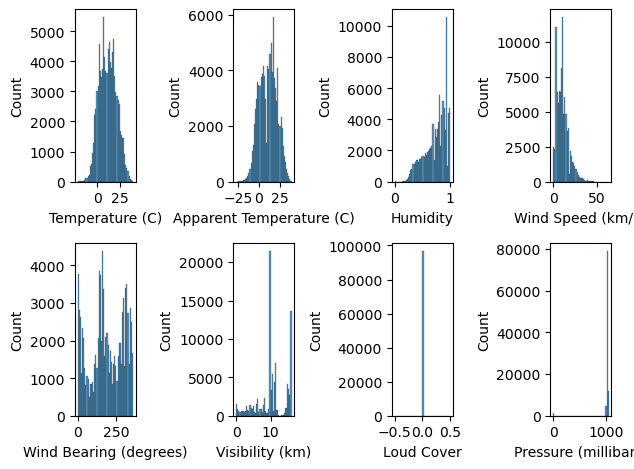

In [11]:
fig, axes = plt.subplots(2,4)
axes= axes.ravel()

for count, col in enumerate (num_cols):
    ax= axes[count]
    sns.histplot(data_df, x= col, ax=ax, bins=50)
    
plt.tight_layout()

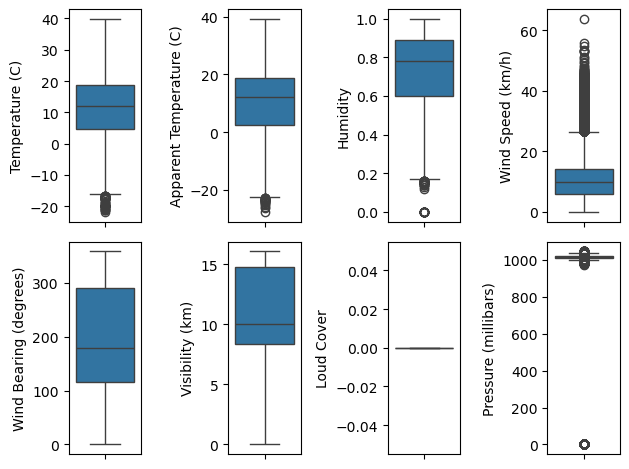

In [12]:
fig, axes = plt.subplots(2,4)
axes= axes.ravel()

for count, col in enumerate (num_cols):
    ax= axes[count]
    sns.boxplot(data=data_df, y= col, ax=ax)
    
plt.tight_layout()

In [13]:
data_df[num_cols].corr()

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars)
Temperature (C),1.000000,0.992629,-0.632255,0.008957,0.029988,0.392847,NaN,-0.005447
Apparent Temperature (C),0.992629,1.000000,-0.602571,-0.056650,0.029031,0.381718,NaN,-0.000219
Humidity,-0.632255,-0.602571,1.000000,-0.224951,0.000735,-0.369173,NaN,0.005454
Wind Speed (km/h),0.008957,-0.056650,-0.224951,1.000000,0.103822,0.100749,NaN,-0.049263
Wind Bearing (degrees),0.029988,0.029031,0.000735,0.103822,1.000000,0.047594,NaN,-0.011651
Visibility (km),0.392847,0.381718,-0.369173,0.100749,0.047594,1.000000,NaN,0.059818
Loud Cover,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pressure (millibars),-0.005447,-0.000219,0.005454,-0.049263,-0.011651,0.059818,NaN,1.000000


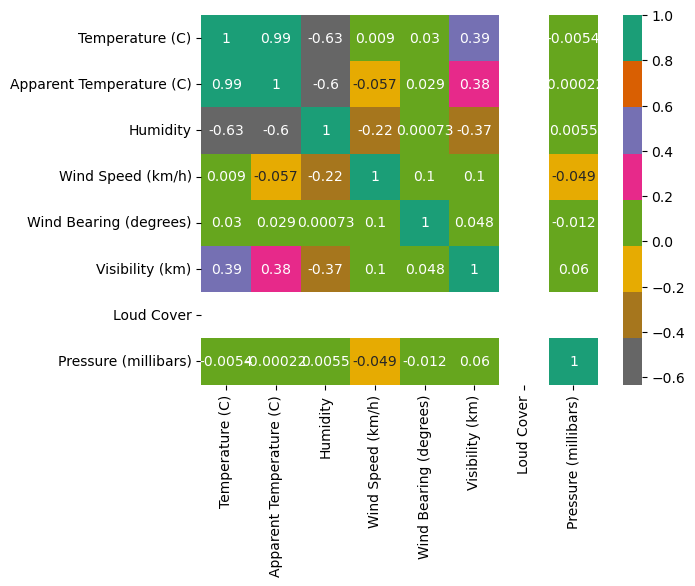

In [14]:
sns.heatmap(data_df[num_cols].corr(),annot=True, cmap='Dark2_r');

In [15]:
tmp_df=data_df[['datetime','Temperature (C)','Visibility (km)','Humidity']]
tmp_df=tmp_df.sort_values('datetime',axis=0, ascending=True)
tmp_df=tmp_df.reset_index(drop= True)
tmp_df.head()

,datetime,Temperature (C),Visibility (km),Humidity
0,2005-12-31 23:00:00+00:00,0.577778,9.9820,0.89
1,2006-01-01 00:00:00+00:00,1.161111,9.9015,0.85
2,2006-01-01 01:00:00+00:00,1.666667,9.9015,0.82
3,2006-01-01 02:00:00+00:00,1.711111,9.9015,0.82
4,2006-01-01 03:00:00+00:00,1.183333,9.9015,0.86


In [34]:
tmp_df= tmp_df.rename({'Temperature (C)':'temp',
                      'Visibility (km)':'viz',
                       'Humidity':'hum'}, axis=1)
tmp_df.head()

,datetime,temp,viz,hum
0,2005-12-31 23:00:00+00:00,0.577778,9.9820,0.89
1,2006-01-01 00:00:00+00:00,1.161111,9.9015,0.85
2,2006-01-01 01:00:00+00:00,1.666667,9.9015,0.82
3,2006-01-01 02:00:00+00:00,1.711111,9.9015,0.82
4,2006-01-01 03:00:00+00:00,1.183333,9.9015,0.86


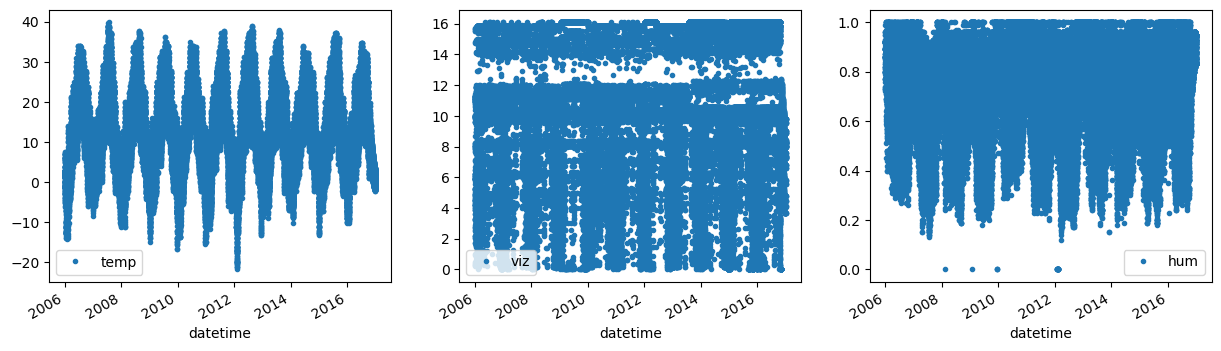

In [38]:
fig= plt.figure(figsize=(15,4))

ax= fig.add_subplot(1,3,1)
tmp_df.plot(x='datetime',y='temp',style='.',ax=ax);

ax= fig.add_subplot(1,3,2)
tmp_df.plot(x='datetime',y='viz',style='.',ax=ax);

ax= fig.add_subplot(1,3,3)
tmp_df.plot(x='datetime',y='hum',style='.',ax=ax);

In [40]:
time_step=24

y_idx= np.arange(time_step, tmp_df.shape[0], time_step)
y_idx.shape

y_df=tmp_df.iloc[y_idx][['datetime','temp']]
y_df.head()

,datetime,temp
24,2006-01-01 23:00:00+00:00,5.422222
48,2006-01-02 23:00:00+00:00,1.694444
72,2006-01-03 23:00:00+00:00,2.200000
96,2006-01-04 23:00:00+00:00,1.666667
120,2006-01-05 23:00:00+00:00,1.805556


In [41]:
y_df.shape[0]*time_step

96432

In [42]:
X_df = tmp_df.iloc[range(len(y_df)*time_step)]
X_df.shape

(96432, 4)

In [43]:
X_temp = np.reshape(X_df['temp'].to_numpy(),
              ( y_df.shape[0],time_step))

X_hum= np.reshape(X_df['hum'].to_numpy(),
              ( y_df.shape[0],time_step))

X_viz=np.reshape(X_df['viz'].to_numpy(),
              ( y_df.shape[0],time_step))

In [44]:
X_temp=X_temp[:, :23]
X_hum=X_temp[:, :23]
X_viz=X_temp[:, :23]
X_viz.shape

(4018, 23)

In [46]:
X_data= np.stack((X_temp, X_hum), axis=2)

X_data.shape

(4018, 23, 2)

# Split Data

In [52]:
split= int(y_df.shape[0]*(1- TEST_SIZE))
X_train= X_data[:split]
X_test= X_data[split:]

y_train = y_df['temp'].to_numpy()[:split]
y_test = y_df['temp'].to_numpy()[split:]

X_train.shape,X_test.shape, y_train.shape, y_test.shape

((3214, 23, 2), (804, 23, 2), (3214,), (804,))

In [53]:
h_units=256
input_shape=(time_step -1,X_train.shape[2])

model=tf.keras.Sequential()

model.add(tf.keras.layers.SimpleRNN(units=h_units,
                                   input_shape=input_shape,
                                   activation='tanh'))
model.add(tf.keras.layers.Dense(1,activation='linear'))

model.compile(loss='mean_squared_error',
              optimizer='adam',
             metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [54]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 256)               66304     
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 66561 (260.00 KB)
Trainable params: 66561 (260.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [55]:
history= model.fit(X_train, y_train,
                  epochs=EPOCHS,
                  batch_size=BATCH_SIZE,
                  validation_data=[X_test,y_test],
                  verbose=2)

Epoch 1/20
101/101 - 4s - loss: 9.8109 - root_mean_squared_error: 3.1322 - val_loss: 0.8963 - val_root_mean_squared_error: 0.9467 - 4s/epoch - 38ms/step
Epoch 2/20
101/101 - 2s - loss: 1.4334 - root_mean_squared_error: 1.1972 - val_loss: 0.8505 - val_root_mean_squared_error: 0.9222 - 2s/epoch - 19ms/step
Epoch 3/20
101/101 - 2s - loss: 1.2199 - root_mean_squared_error: 1.1045 - val_loss: 0.7017 - val_root_mean_squared_error: 0.8377 - 2s/epoch - 21ms/step
Epoch 4/20
101/101 - 2s - loss: 1.0909 - root_mean_squared_error: 1.0445 - val_loss: 0.8295 - val_root_mean_squared_error: 0.9108 - 2s/epoch - 21ms/step
Epoch 5/20
101/101 - 2s - loss: 1.0772 - root_mean_squared_error: 1.0379 - val_loss: 0.6847 - val_root_mean_squared_error: 0.8275 - 2s/epoch - 21ms/step
Epoch 6/20
101/101 - 2s - loss: 1.0835 - root_mean_squared_error: 1.0409 - val_loss: 0.7776 - val_root_mean_squared_error: 0.8818 - 2s/epoch - 21ms/step
Epoch 7/20
101/101 - 2s - loss: 1.0647 - root_mean_squared_error: 1.0318 - val_los

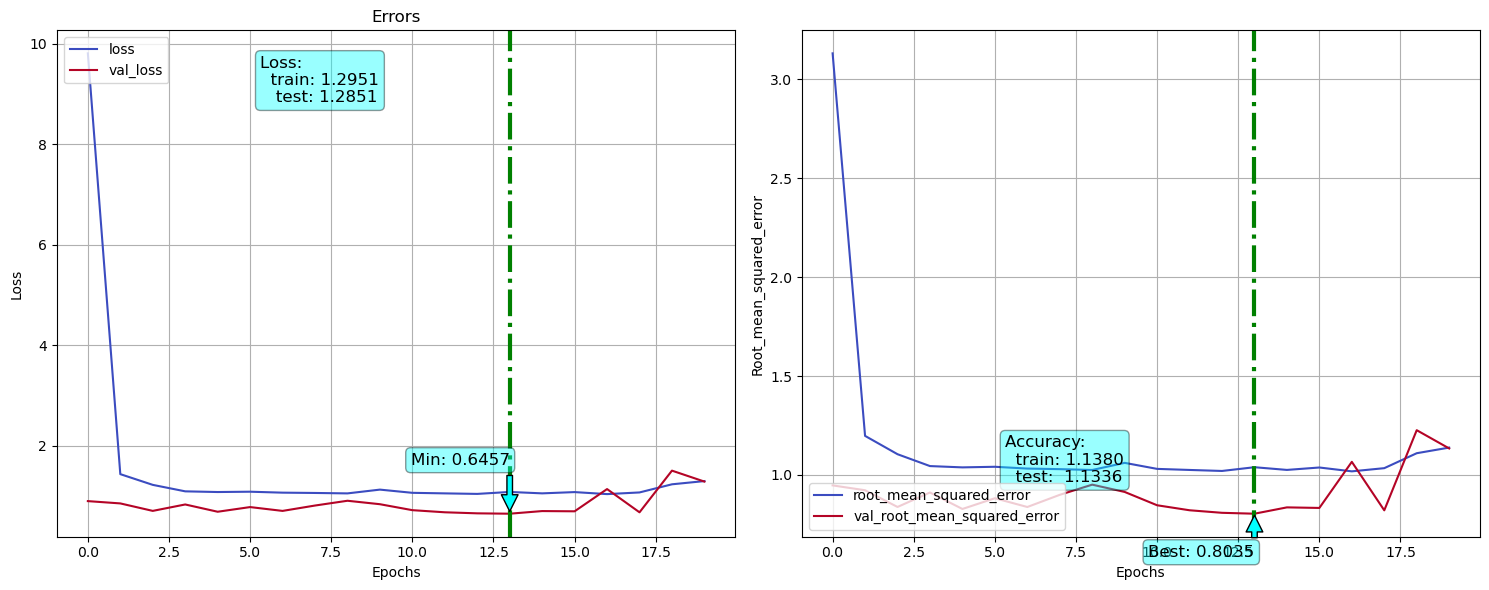

In [56]:
loss_df= pd.DataFrame(history.history)
fn_plot_tf_hist(loss_df)

In [57]:
y_train_pred= model.predict(X_train)
y_test_pred= model.predict(X_test)
y_pred= np.append(y_train_pred, y_test_pred)

y_pred.shape

26/26 [==============================] - 0s 9ms/step


(4018,)

In [58]:
res_df= y_df.copy()
res_df['pred']= y_pred
res_df['datetime']= res_df['datetime'].dt.date
res_df.head()

,datetime,temp,pred
24,2006-01-01,5.422222,4.165659
48,2006-01-02,1.694444,1.341420
72,2006-01-03,2.200000,1.376625
96,2006-01-04,1.666667,1.248161
120,2006-01-05,1.805556,1.768617


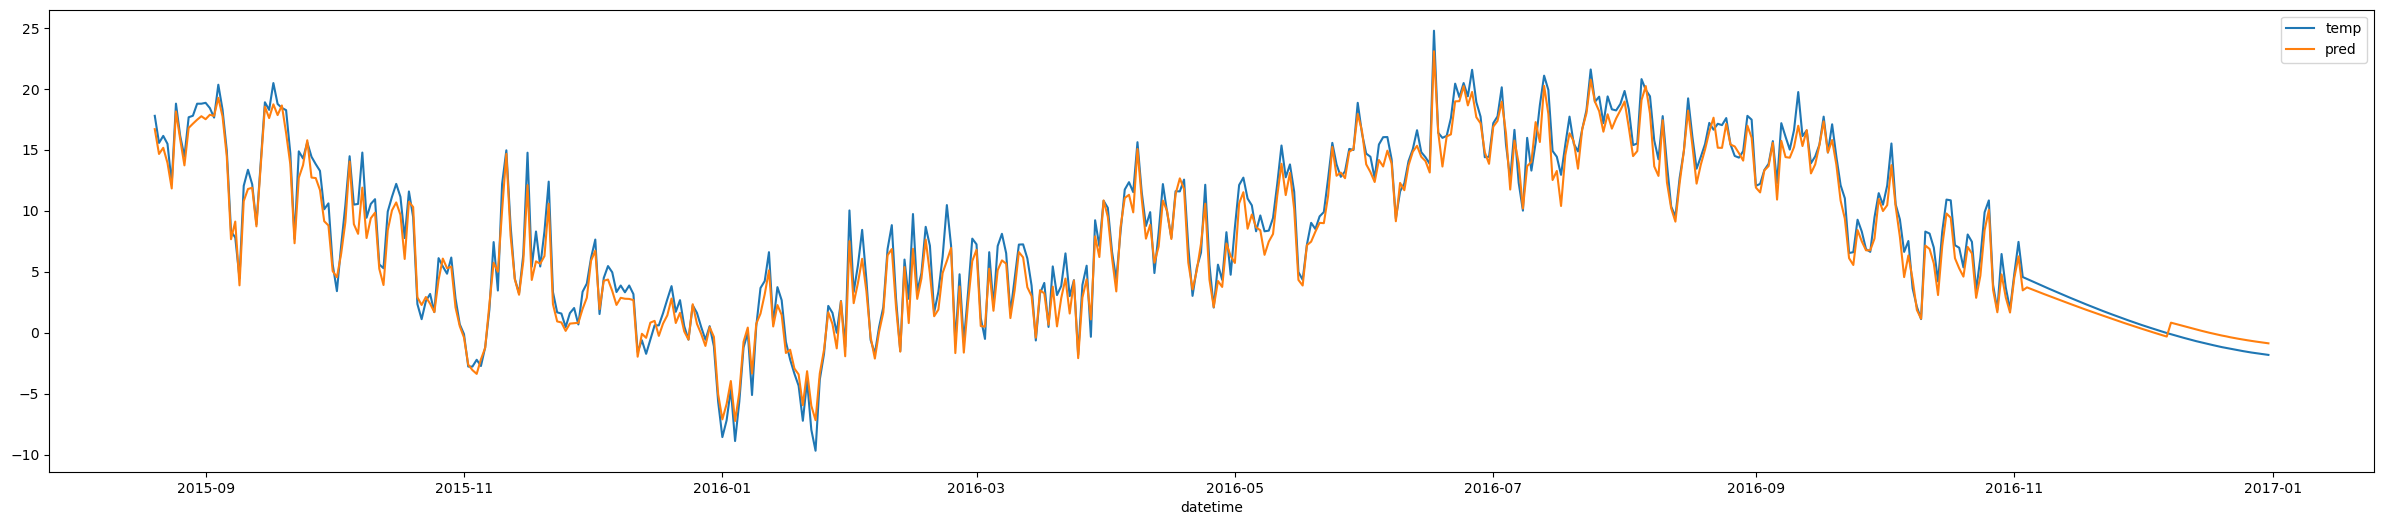

In [59]:
fig, ax=plt.subplots(figsize=(30,6))
res_df[-500:].plot(x='datetime',y=[ 'temp' ,'pred'],ax=ax);